In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from gym.envs.toy_text.blackjack import BlackjackEnv, sum_hand

class CustomBlackjackEnv(BlackjackEnv):
    """
    A custom Blackjack environment that extends the Gym Blackjack environment to include
    custom functionalities such as resetting to a specific observation state and rendering
    with different modes.

    Attributes:
        x (int): The maximum player sum value considered in the observation space.
        y (int): The maximum dealer's showing card value considered in the observation space.
        z (int): The binary flag indicating the presence of a usable ace in the observation space.
        state_space (list of tuples): The set of all possible states (player sum, dealer card, usable ace flag).
        render_mode (str): The mode used for rendering. Supported modes include 'human' for console output
                           and 'rgb_array' for graphical rendering (not implemented).

    Parameters:
        natural (bool): Flag to determine whether natural blackjack pays out 1.5x. Defaults to False.
        sab (bool): Flag for following the "start-at-beginning" rule from Sutton and Barto's book. Defaults to True.
        render_mode (str): The rendering mode. Defaults to 'human'.

    GPT:
        GPT-4 was used to generate the docstrings in this class.
    """

    def __init__(self, natural=False, sab=True, render_mode="human"):
        super().__init__(natural=natural, sab=sab)
        self.x = self.observation_space[0].n
        self.y = self.observation_space[1].n
        self.z = self.observation_space[2].n
        self.state_space = [(a, b, c) for a in range(self.x) for b in range(self.y) for c in range(self.z)]
        self.render_mode = render_mode

    def render(self, mode='human'):
        """
        Renders the current state of the environment according to the specified mode.

        Parameters:
            mode (str): The rendering mode. Supported values are 'human' and 'rgb_array'.
                        The 'rgb_array' mode is not implemented and will print a placeholder message.
        """
        if mode != self.render_mode:
            print(f"Rendering mode set to {self.render_mode}, but trying to render with {mode}.")
            return

        if mode == 'human':
            player_hand_str = [self.card_to_str(card) for card in self.player]
            dealer_hand_str = [self.card_to_str(card) for card in self.dealer]
            print(f"Player's hand: {player_hand_str} with sum: {sum_hand(self.player)}")
            print(f"Dealer's showing card: {self.card_to_str(self.dealer[0])}")
            print(f"Dealer's hand: {dealer_hand_str} with sum: {sum_hand(self.dealer)}")
        elif mode == 'rgb_array':
            print("Graphical rendering not implemented.")

    def card_to_str(self, card):
        """
        Converts a card number to its string representation.

        Parameters:
            card (int): The card number.

        Returns:
            str: The string representation of the card.
        """
        if card == 1:
            return 'Ace'
        elif card in [11, 12, 13]:
            return {11: 'Jack', 12: 'Queen', 13: 'King'}[card]
        else:
            return str(card)

    def custom_reset(self, observation=None):
        """
        Resets the environment to a specific state based on the provided observation.

        Parameters:
            observation (tuple): A tuple containing the player total, dealer showing card,
                                  and usable ace flag to reset the state to. If None, the environment
                                  is reset to a random state.

        Returns:
            tuple: The initial observation of the reset environment.
        """
        super().reset()
        if observation:
            player_total, dealer_showing, usable_ace = observation
            if usable_ace:
                self.player = [6, 1] if player_total == 17 else [player_total - 11, 1]
            else:
                self.player = [player_total - 10, 10]
            self.dealer = [dealer_showing, np.random.randint(1, 11)]
        return self._get_obs()

env = CustomBlackjackEnv()

# Demonstrate usage.
print(f"env.reset() = {env.reset()}")
env.render()


env.reset() = (7, 10, False)
Player's hand: ['3', '4'] with sum: 7
Dealer's showing card: 10
Dealer's hand: ['10', 'Ace'] with sum: 21


In [18]:
print(f"{env.custom_reset() = } \n")
env.render()
print()
print(f"{env.step(1) = } \n")
env.render()


env.custom_reset() = (21, 10, True) 

Player's hand: ['Ace', '10'] with sum: 21
Dealer's showing card: 10
Dealer's hand: ['10', '9'] with sum: 19

env.step(1) = ((17, 10, False), 0.0, False, {}) 

Player's hand: ['Ace', '10', '6'] with sum: 17
Dealer's showing card: 10
Dealer's hand: ['10', '9'] with sum: 19


In [19]:

def generate_episode(env, policy, starting_state=None, starting_action=None):
    """
    Generates an episode by simulating interactions with the environment based on a given policy.

    This function iterates through the steps of an episode, beginning with an optional starting state
    and/or action, and continues until the environment returns a termination or truncation signal. At each
    step, it records the state, action taken, and reward received, appending these details to the episode
    history. The episode ends when the environment indicates termination (the episode naturally concludes)
    or truncation (the episode reaches a predefined limit, such as a maximum number of steps).

    Parameters:
        env: The environment object compliant with the OpenAI Gym interface. This environment should
             have a `custom_reset` method that optionally takes an observation as an argument to set
             the starting state of the environment, and a `step` method that takes an action and returns
             the next state, reward, and termination or truncation flags.
        policy: A dictionary mapping from state to action or a function that takes a state as input and
                returns an action. The policy dictates the action to be taken in each state.
        starting_state (optional): The initial state from which to start the episode. If not provided,
                                   the environment's reset method is used to obtain the initial state.
        starting_action (optional): The first action to take in the episode. If not specified, the action
                                    is selected based on the provided policy.

    Returns:
        episode: A list of tuples, where each tuple contains (state, action, reward) representing the
                 sequence of steps taken in the episode. Each tuple represents a step in the environment,
                 capturing the state before the action, the action taken, and the immediate reward received.

    Example:
        >>> env = CustomBlackjackEnv()
        >>> policy = {state: 0 for state in env.state_space}  # Example policy: always stick
        >>> episode = generate_episode(env, policy)
        >>> print(episode[0])  # Prints the first step of the episode

    GPT:
        GPT-4 was used to generate the docstrings in this function.
    """
    episode = []
    state = env.custom_reset(observation=starting_state)
    while True:
        action = starting_action if starting_action else policy[state]
        next_state, reward, terminated, truncated = env.step(action)
        episode.append((state, action, reward))
        if terminated or truncated:
            break
        state = next_state
    return episode

In [20]:
# Define random policy.
random_policy = {state: env.action_space.sample() for state in env.state_space}

In [21]:
# "What does a episode look like?"
episode = generate_episode(env, random_policy)
for state, action, reward in episode:
    env.render()
    print(f"s = {state}, a = {action}, r = {reward} \n")
env.render()

Player's hand: ['2', '8'] with sum: 10
Dealer's showing card: 9
Dealer's hand: ['9', '10'] with sum: 19
s = (10, 9, False), a = 0, r = -1.0 

Player's hand: ['2', '8'] with sum: 10
Dealer's showing card: 9
Dealer's hand: ['9', '10'] with sum: 19


In [22]:
def first_visit_monte_carlo(env, policy, gamma=1.0, num_episodes=5_000):
    """
    Estimates the value function V for a given policy using the First-Visit Monte Carlo method.

    This function iteratively generates episodes according to the given policy and updates the
    value function estimate for each state based on the returns following the first visit to that state.
    It operates under the assumption of episodic tasks, meaning each episode eventually reaches a
    terminal state.

    Parameters:
        env: The environment object that adheres to the OpenAI Gym interface. The environment should
             have a `state_space` attribute listing all possible states and support the generation of
             episodes via the `generate_episode` function.
        policy: A policy under which episodes are generated, defined as a mapping from states to actions.
                The policy dictates the behavior of the agent in the environment and is assumed to be fixed
                and deterministic in this context.
        gamma (float): The discount factor, specifying the importance of future rewards. It must be a value
                       between 0 and 1, inclusive. A value of 0 means "only consider immediate rewards", while
                       1 means "consider future rewards just as important as immediate ones".
        num_episodes (int): The number of episodes to generate for estimating the value function. More episodes
                            typically lead to a more accurate estimate, at the cost of increased computation.

    Returns:
        V (dict): A dictionary mapping states to their estimated values under the given policy. Represents the
                  value function V(s) ≈ v_π(s), which estimates the expected return from each state s under the
                  policy π.

    Example:
        >>> env = CustomBlackjackEnv()
        >>> policy = {state: 0 for state in env.state_space}  # Example: always stick
        >>> V = first_visit_monte_carlo(env, policy)
        >>> print(V[(13, 2, False)])  # Example: estimated value of having 13, dealer showing 2, no usable ace

    GPT:
        GPT-4 was used to generate the docstrings in this function.
    """
    # Initialize the value function randomly.
    V = {state: np.random.rand() for state in env.state_space}

    # Initialize the Reward variable with empty lists for each state.
    R = {state: [] for state in env.state_space}

    for _ in range(num_episodes):
        episode = generate_episode(env, policy)
        states, actions, rewards = zip(*episode)
        G = 0.0  # Initialize the expected return.
        T = len(episode)  # Get the terminal time state T.

        # Loop backwards through the episode
        for t in range(T-1, -1, -1):
            G = gamma * G + rewards[t]  # Update return
            # If the state at time t is not in the list of states before t
            if states[t] not in states[:t]:
                R[states[t]].append(G)  # Append return to state's returns list
                V[states[t]] = np.mean(R[states[t]])  # Update state's value as average of returns

    return V


In [23]:
# Compute the value function for the random policy.
V = first_visit_monte_carlo(env, random_policy, num_episodes=5_000)

# Print the value function for the random policy.
print("------------- Value Function for Random Policy ----------------")
i = 0
for state, value in V.items():
    if i < 10:
        print(f"V[{state}] = {V[state]}")
    else:
        break
    i += 1

------------- Value Function for Random Policy ----------------
V[(0, 0, 0)] = 0.40731548044172194
V[(0, 0, 1)] = 0.4877305908615439
V[(0, 1, 0)] = 0.27261437374393815
V[(0, 1, 1)] = 0.053295517935075254
V[(0, 2, 0)] = 0.009124531145595638
V[(0, 2, 1)] = 0.7918780150949308
V[(0, 3, 0)] = 0.9584580587802966
V[(0, 3, 1)] = 0.9244005477391041
V[(0, 4, 0)] = 0.9875636327445614
V[(0, 4, 1)] = 0.6520407687253699


In [24]:
# Sutton & Barto BlackJack policy from the Monte Carlo Chapter.
sab_policy = {state: int(state[0] < 20) for state in env.state_space}

# Compute the value function for the Sutton & Barto policy.
V = first_visit_monte_carlo(env, sab_policy)

# Print the value function for the Sutton & Barto policy.
print("------------- Value Function for Sutton & Barto Policy ----------------")
i = 0
for state, value in V.items():
    if i < 10:
        print(f"V[{state}] = {V[state]}")
    else:
        break
    i += 1

------------- Value Function for Sutton & Barto Policy ----------------
V[(0, 0, 0)] = 0.19065872162497388
V[(0, 0, 1)] = 0.9603421214954246
V[(0, 1, 0)] = 0.6694159029077444
V[(0, 1, 1)] = 0.9180761137749738
V[(0, 2, 0)] = 0.8450134240510206
V[(0, 2, 1)] = 0.29542295267490293
V[(0, 3, 0)] = 0.22400524836089575
V[(0, 3, 1)] = 0.1858603676736894
V[(0, 4, 0)] = 0.07029263721719037
V[(0, 4, 1)] = 0.08561491986336456


In [25]:

def prepare_data_for_plot(V, usable_ace):
    player_sums = sorted(set(key[0] for key in V.keys() if 12 <= key[0] <= 21 and key[2] == usable_ace))
    dealer_showing = sorted(set(key[1] for key in V.keys() if key[2] == usable_ace))
    Y, X = np.meshgrid(player_sums, dealer_showing)
    Z = np.zeros_like(X, dtype=float)

    # Outer loop for dealer's card.
    for i, dealer_card in enumerate(dealer_showing):
        # Inner loop for player's sum.
        for j, player_sum in enumerate(player_sums):
            # Assign values accordingly.
            Z[i, j] = V.get((player_sum, dealer_card, usable_ace), np.nan)

    return X, Y, Z

def plot_value_function(V, usable_ace, title):
    X, Y, Z = prepare_data_for_plot(V, usable_ace)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Dealer\'s Showing Card')
    ax.set_ylabel('Player\'s Current Sum')
    ax.set_zlabel('Value')
    ax.set_title(title)
    fig.colorbar(surf)
    plt.show()

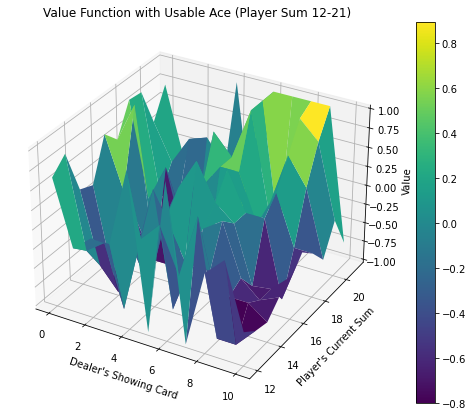

In [26]:
# Compute the value function for the random policy with 5_000 episodes.
V = first_visit_monte_carlo(env, random_policy, num_episodes=5_000)

# Plot for states with a usable ace, with axes switched
plot_value_function(V, 1, 'Value Function with Usable Ace (Player Sum 12-21)')

In [27]:
# Compute the value function for the Sutton & Barto policy with 500_000 iterations.
# Note, this will take a few minutes..... Using Chapter 2 for inspiration, can you make this faster?
V = first_visit_monte_carlo(env, sab_policy, num_episodes=30_000)

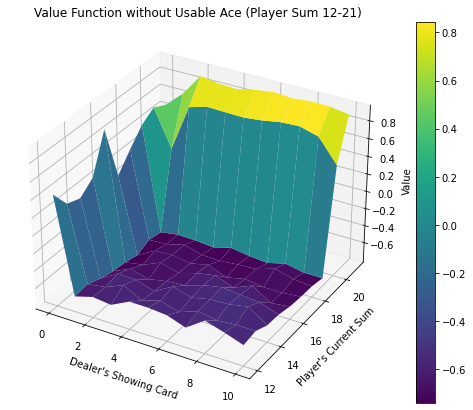

In [28]:
# Plot for states without a usable ace.
plot_value_function(V, 0, 'Value Function without Usable Ace (Player Sum 12-21)')

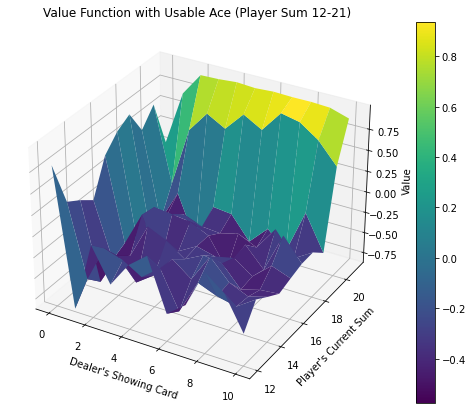

In [29]:
# Plot for states with a usable ace.
plot_value_function(V, 1, 'Value Function with Usable Ace (Player Sum 12-21)')

In [30]:
def prepare_data_for_plot(V, usable_ace):
    player_sums = sorted(set(key[0] for key in V.keys() if 12 <= key[0] <= 21 and key[2] == usable_ace))
    dealer_showing = sorted(set(key[1] for key in V.keys() if key[2] == usable_ace))
    Y, X = np.meshgrid(player_sums, dealer_showing)
    Z = np.zeros_like(X, dtype=float)

    for i, dealer_card in enumerate(dealer_showing):
        for j, player_sum in enumerate(player_sums):
            Z[i, j] = V.get((player_sum, dealer_card, usable_ace), np.nan)

    return X, Y, Z

def plot_value_function_subplot(V_first, V_second, title_first, title_second):
    fig = plt.figure(figsize=(20, 14))

    for i, usable_ace in enumerate([0, 1]):
        X, Y, Z_first = prepare_data_for_plot(V_first, usable_ace)
        ax = fig.add_subplot(2, 2, i + 1, projection='3d')
        surf = ax.plot_surface(X, Y, Z_first, cmap='viridis', edgecolor='none')
        ax.set_xlabel("Dealer's Showing Card")
        ax.set_ylabel("Player's Current Sum")
        ax.set_zlabel('Value')
        ax.set_title(f"{title_first} - Usable Ace: {bool(usable_ace)}")
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

        X, Y, Z_second = prepare_data_for_plot(V_second, usable_ace)
        ax = fig.add_subplot(2, 2, i + 3, projection='3d')
        surf = ax.plot_surface(X, Y, Z_second, cmap='viridis', edgecolor='none')
        ax.set_xlabel("Dealer's Showing Card")
        ax.set_ylabel("Player's Current Sum")
        ax.set_zlabel('Value')
        ax.set_title(f"{title_second} - Usable Ace: {bool(usable_ace)}")
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.show()

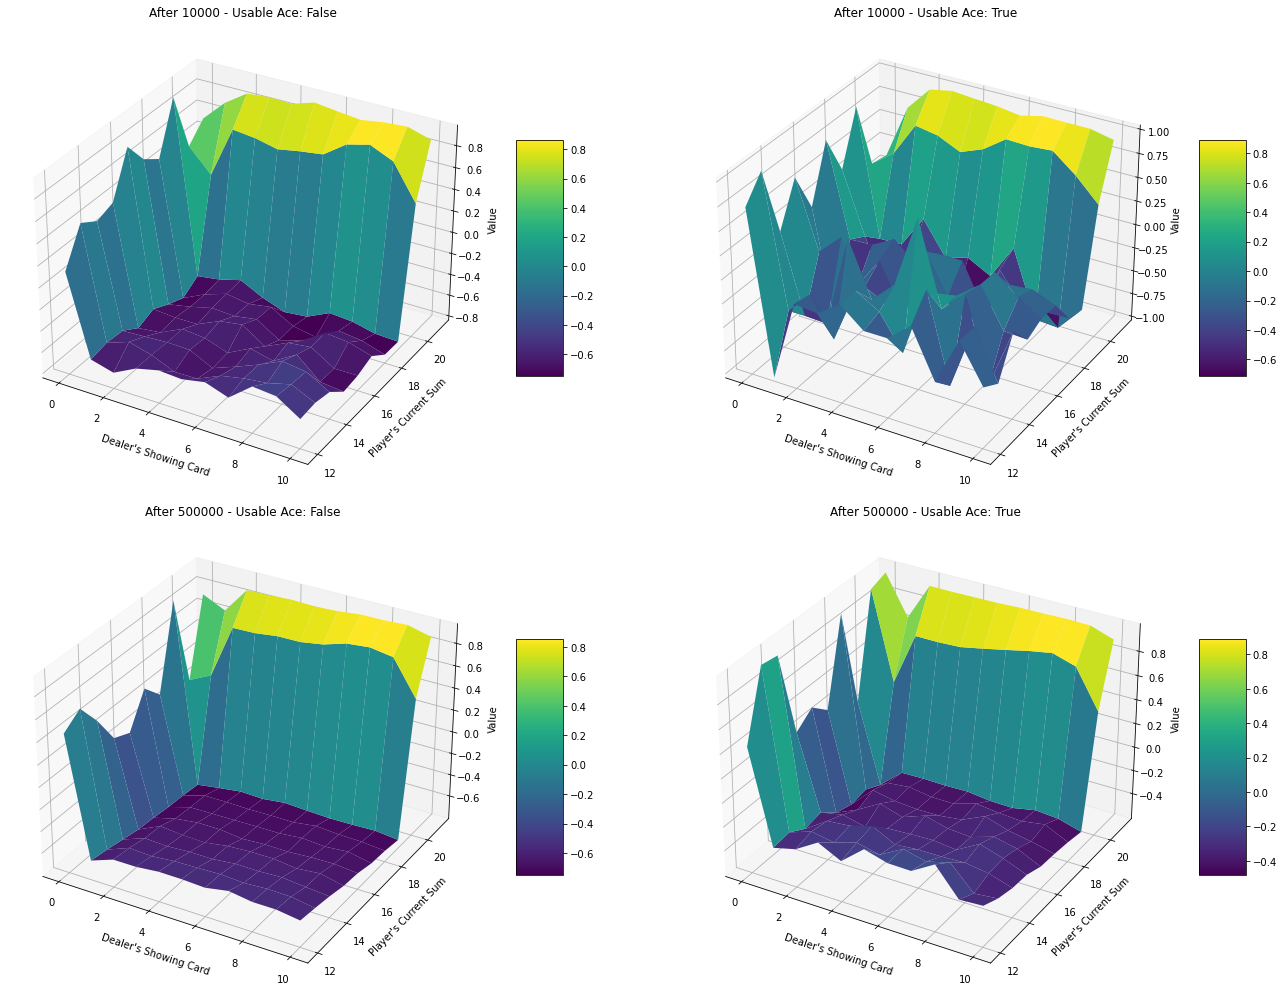

In [31]:
first_num_episodes = 10_000
second_num_episodes = 500_000

# Generate Figure 5.1 from Sutton & Barto's book.
V_first = first_visit_monte_carlo(env, sab_policy, num_episodes=first_num_episodes)
V_second = first_visit_monte_carlo(env, sab_policy, num_episodes=second_num_episodes)

plot_value_function_subplot(V_first, V_second, f'After {first_num_episodes}', f'After {second_num_episodes}')

In [32]:
# Monte Carlo ES (Exploring Starts), for estimating $π = π_*$.
def monte_carlo_es(env, num_episodes=5000, gamma=1.0):
    """
    Performs Monte Carlo with Exploring Starts (MC-ES) for policy estimation.

    This function estimates an optimal policy π ≈ π* for a given environment by
    exploring starting state-action pairs randomly and updating the policy based
    on the returns received. It uses the First-Visit MC method for each state-action
    pair encountered in each episode.

    Parameters:
        env (gym.Env): The environment to train the policy against, which should follow
                       the OpenAI Gym interface and include a 'state_space' and an 'action_space'.
        num_episodes (int): The number of episodes to run the MC-ES algorithm for. Defaults to 5000.
        gamma (float): The discount factor used to calculate the return of an episode.
                       It must be a value between 0 and 1, where 1 considers future rewards
                       as important as immediate rewards, and 0 considers only immediate rewards.

    Returns:
        pi (dict): A dictionary mapping from each state to an action, representing the
                   estimated optimal policy after the given number of episodes.

    Example:
        >>> env = CustomBlackjackEnv()
        >>> optimal_policy = monte_carlo_es(env, num_episodes=10000)
        >>> print(optimal_policy)

    Note:
        The environment must have a method `state_space` that provides a list of all possible states
        and an `action_space` that provides the number of possible actions. The `action_space` must
        also have a `sample()` method for random action selection.
    """

    # Get the total number of states - this will be used below to randomly
    # select an index to pick a random state.
    num_states = len(env.state_space)

    # Initialize the policy to be random.
    pi = {state : env.action_space.sample() for state in env.state_space}

    # Initialize the Q-table: (s, a) -> random Real number for each (s, a) tuple.
    Q = {
        (state, action) : np.random.rand()
        for state in env.state_space
        for action in range(env.action_space.n)
    }

    # Initialize the Returns: (s, a) -> empty list for each (s, a) tuple.
    R = {
        (state, action) : []
        for state in env.state_space
        for action in range(env.action_space.n)
    }

    # For each episode...
    for _ in range(num_episodes):

        # Choose random state and action with equal probability.
        state_index = np.random.choice(range(num_states))
        state, action = env.state_space[state_index], env.action_space.sample()

        # Generate an episode following the current policy pi.
        episode = generate_episode(env, pi, starting_state=state, starting_action=action)
        episode.reverse()

        # Initialize the return.
        G = 0

        # Unpack the episode into tuples.
        states, actions, rewards = zip(*episode)

        # Get the terminal time step T.
        T = len(states)

        # For each step t in T-1, T-2, ..., 2, 1, 0 in the episode.
        for t in range(T-1, -1, -1):

            # G <- gamma * G + R_{t+1}
            G = gamma * G + rewards[t]

            # Check that S_t is not in S_0, S_1, ..., S_{t-1}.
            if (states[t], actions[t]) not in zip(states[:t], actions[:t]):

                # Update the return for (S_t, A_t).
                R[(states[t], actions[t])].append(G)

                # Update the Q-value for (S_t, A_t).
                Q[(states[t], actions[t])] = np.mean(R[(states[t], actions[t])])

                # Update the policy.
                pi[states[t]] = np.argmax([Q[(states[t], action)] for action in range(env.action_space.n)])
    return pi

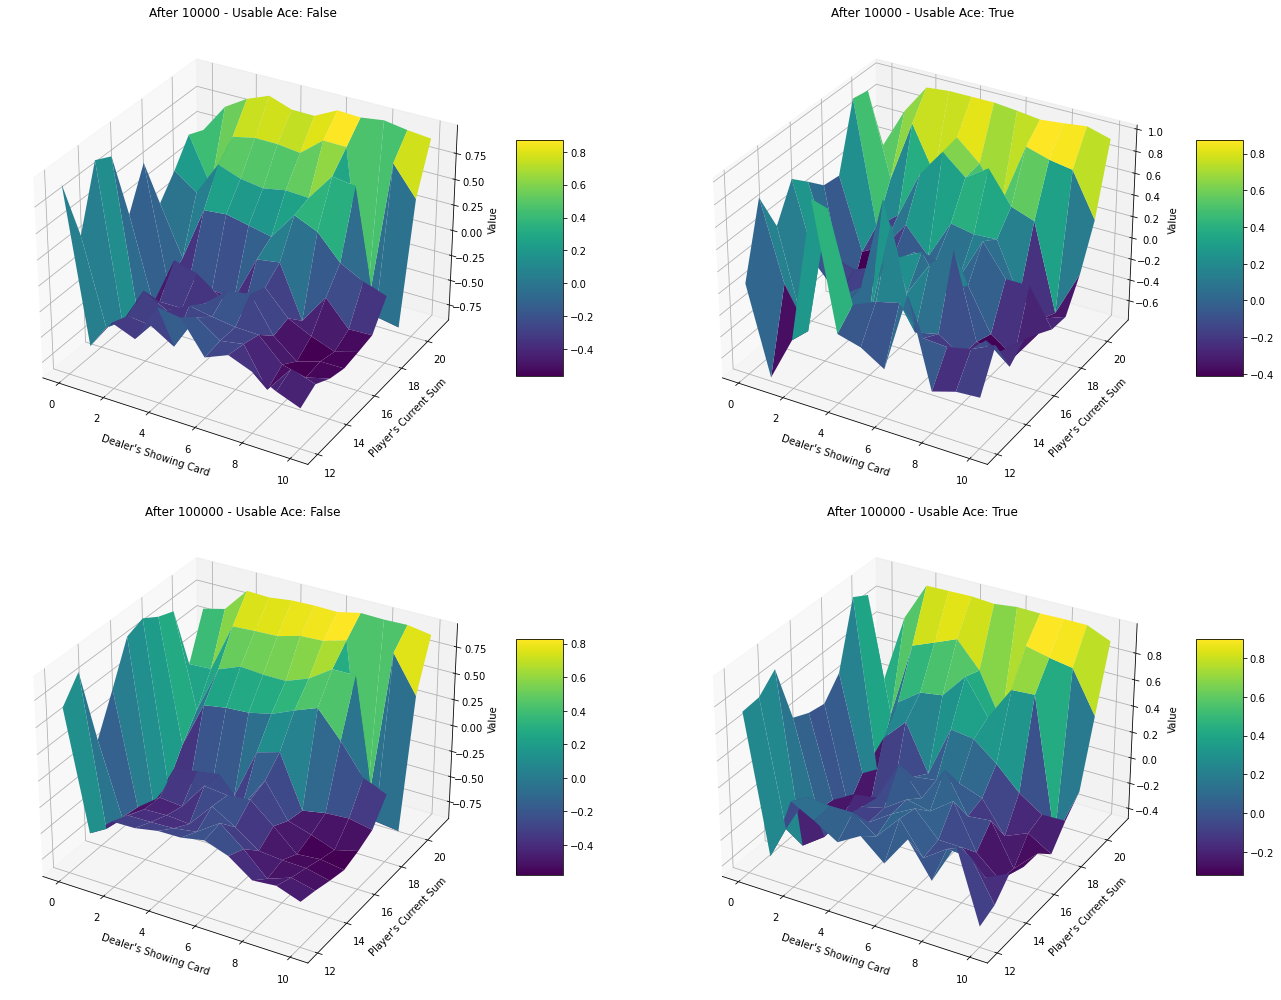

In [35]:
first_num_episodes = 10_000
second_num_episodes = 100_000
# Compute a better than guessing policy using Monte Carlo Exploring Starts.
pi = monte_carlo_es(env, num_episodes=50_000)

# Generate Figure 5.1 from Sutton & Barto's book.
V_first = first_visit_monte_carlo(env, pi, num_episodes=first_num_episodes)
V_second = first_visit_monte_carlo(env, pi, num_episodes=second_num_episodes)

plot_value_function_subplot(V_first, V_second, f'After {first_num_episodes}', f'After {second_num_episodes}')

In [37]:
wins = 0
losses = 0
for _ in range(10_000):
    episode = generate_episode(env, random_policy)
    if episode[0][-1] == 1:
        wins += 1
    else:
        losses += 1

print("-"*50)
print(f'Random Policy Wins: {wins}')
print(f'Random Policy Losses: {losses} \n')

wins = 0
losses = 0
for _ in range(10_000):
    episode = generate_episode(env, sab_policy)
    if episode[0][-1] == 1:
        wins += 1
    else:
        losses += 1

print("-"*50)
print(f'Sutton & Barto Policy Wins: {wins}')
print(f'Sutton & Barto Policy Losses: {losses} \n')


# Compute a better than guessing policy using Monte Carlo Exploring Starts.
pi = monte_carlo_es(env, num_episodes=500_000)

wins = 0
losses = 0
for _ in range(10_000):
    episode = generate_episode(env, pi)
    if episode[0][-1] == 1:
        wins += 1
    else:
        losses += 1

print("-"*50)
print(f'Monte Carlo Policy Wins: {wins}')
print(f'Monte Carlo Policy Losses: {losses}')

--------------------------------------------------
Random Policy Wins: 2142
Random Policy Losses: 7858 

--------------------------------------------------
Sutton & Barto Policy Wins: 1130
Sutton & Barto Policy Losses: 8870 

--------------------------------------------------
Monte Carlo Policy Wins: 1819
Monte Carlo Policy Losses: 8181


In [38]:


# On policy first visit Monte Carlo, for estimating $\pi \approx \pi_*$.
def on_policy_first_visit_monte_carlo(env, env_actions, num_episodes=5_000, gamma=1.0, epsilon=0.025):

    # Get the total number of states - this will be used below to randomly
    # select an index to pick a random state.
    num_states = len(env.state_space)

    # Initialize the policy to be random.
    pi = {state: np.random.choice(env_actions) for state in env.state_space}

    # Initialize the Q-table: (s, a) -> random Real number for each (s, a) tuple.
    Q = {
        (state, action) : np.random.rand()
        for state in env.state_space
        for action in range(env.action_space.n)
    }

    # Initialize the Returns: (s, a) -> empty list for each (s, a) tuple.
    R = {
        (state, action) : []
        for state in env.state_space
        for action in range(env.action_space.n)
    }

    # For each episode...
    for _ in range(num_episodes):

        # Choose random state and action with equal probability.
        state_index = np.random.choice(range(num_states))
        state, action = env.state_space[state_index], env.action_space.sample()

        # Generate an episode following the current policy pi.
        episode = generate_episode(env, pi)
        episode.reverse()

        # Initialize the return.
        G = 0

        # Unpack the episode into tuples.
        states, actions, rewards = zip(*episode)

        # Get the terminal time step T.
        T = len(states)

        # For each step t in T-1, T-2, ..., 2, 1, 0 in the episode.
        for t in range(T-1, -1, -1):

            # G <- gamma * G + R_{t+1}
            G = gamma * G + rewards[t]

            # Check that S_t is not in S_0, S_1, ..., S_{t-1}.
            if not (states[t] in states[:t] or actions[t] in actions[:t]):
                # Update the return for (S_t, A_t).
                R[(states[t], actions[t])].append(G)

                # Update the Q-value for (S_t, A_t).
                Q[(states[t], actions[t])] = np.mean(R[(states[t], actions[t])])

                # Update the policy.
                A_star = np.argmax(Q[(states[t], actions[t])])
                probabilities = []
                for action in env_actions:
                    if action == A_star:
                        probabilities.append(1.0 - epsilon + (epsilon / len(env_actions)))
                    else:
                        probabilities.append(epsilon / len(env_actions))
                pi[(state,)] = np.random.choice(env_actions, p=probabilities)
    return pi

In [39]:
pi = on_policy_first_visit_monte_carlo(env, [0, 1], num_episodes=10_000, epsilon=0.001)

# Play 10_000 games using the learned policy and print the win percentage.
wins = 0
losses = 0
for _ in range(10_000):
    episode = generate_episode(env, pi)
    if episode[0][-1] == 1:
        wins += 1
    else:
        losses += 1

print(f'Wins: {wins}')
print(f'Losses: {losses}')

Wins: 1839
Losses: 8161
